In [87]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.lgbm_model import LGBM_Model
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Model Explanation

- There are 5 models in total.

- The base model is created by the base features which contain 20 raw features and 13 preprocessed features.

- Since there are some users(bacno) in both training and testing set, I created other 4 special features captured the information of the label.

- The each of other four models is trained by the base features plus one special feature.

- If the transaction in testing meets the conditions of special features, that transaction is predicted by the corresponding special model. Otherwise the transaction is predicted by the base model.

# What made my model successful?

- I just create few new features which makes my models simple and have better generalizaiton.

- I replace the value of categorical features of training set with NA if the value is not in testing set so that the model will not learn something useless when apply in testing set. The model can learn more focus on the value which exists in testing set. 

- I split the training set by GroupKFold which i group the sample by user(bacno) so i may have better early stopping which prevents overfitting and underfitting

- Since some of the predictions of testing set are very extreme between folds, i drop the prediction of the fold if it is out of 1 standard deviation boundary

# Define features

These are the features i used in the model

In [4]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',
                                  'cano_locdt_txkey_count',
                                  'bacno_locdt_mchno_txkey_count'
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',
                    'mchno_in_fraud_mchno_list',
                    'conam_in_fraud_conam_list',
                    'diff_with_first_fraud_locdt'
                               ]

base_features =  (    raw_bool_features 
                    + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features
                       )

label = 'fraud_ind'

# Preprocess

In [6]:
preprocess_group = True
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

# Base features

In [18]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)
input_features = base_features 
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train.tail(10)

,ecfg,flbmk,flg_3dsmk,insfg,ovrlt,contp,stscd,etymd,stocn,mcc,csmcu,hcefg,bacno,cano,mchno,acqic,scity,loctm,conam,iterm,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,last_time_days,next_time_days,cano_locdt_global_time_std,diff_locdt_with_last_trans_cano,diff_locdt_of_two_card,cano_locdt_conam_min,cano_locdt_conam_max,diff_gtime_with_conam_zero_trans_locdt,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index
1943429,0,0,0,0,0,5.0,0.0,5.0,102.0,292.0,62.0,5.0,NaN,NaN,47022,6716.0,4526.0,202808.0,815.08,0,9,1,1,99046.0,NaN,NaN,0,NaN,815.08,815.08,NaN,0,1
1943430,1,0,0,0,0,5.0,0.0,8.0,102.0,209.0,62.0,5.0,NaN,NaN,38207,6322.0,5817.0,61702.0,750.24,0,9,3,1,NaN,-46675.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943431,0,0,0,0,0,5.0,0.0,5.0,102.0,270.0,62.0,5.0,NaN,NaN,39044,6716.0,5820.0,191457.0,841.64,0,9,3,1,46675.0,-7720.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943432,0,0,0,0,0,5.0,0.0,5.0,102.0,306.0,62.0,5.0,NaN,NaN,88672,5975.0,5817.0,212337.0,381.65,0,9,3,1,7720.0,-84800.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943433,0,0,0,0,0,5.0,0.0,5.0,102.0,192.0,62.0,5.0,NaN,NaN,NaN,5975.0,5817.0,205657.0,366.38,0,9,1,1,84800.0,-240959.0,NaN,-12,NaN,366.38,366.38,NaN,0,1
1943434,0,0,0,0,0,5.0,0.0,5.0,102.0,288.0,62.0,5.0,NaN,NaN,NaN,5975.0,5817.0,155256.0,1119.11,0,9,4,1,240959.0,-5347.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943435,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,NaN,NaN,6475,6767.0,5817.0,172203.0,1334.91,0,9,4,3,5347.0,-2025.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943436,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,NaN,NaN,6475,6767.0,5817.0,175548.0,1125.71,0,9,4,3,2025.0,-735.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,2
1943437,0,0,0,0,0,5.0,0.0,5.0,102.0,247.0,62.0,5.0,NaN,NaN,6475,6767.0,5817.0,180803.0,1103.64,0,9,4,3,735.0,-749289.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,3
1943438,1,0,0,1,0,5.0,0.0,8.0,102.0,247.0,62.0,5.0,NaN,NaN,82174,6769.0,5817.0,101612.0,1194.66,1,9,1,1,749289.0,NaN,NaN,0,NaN,1194.66,1194.66,NaN,0,1


# Base Model

In [7]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 33), test shape: (421665, 33)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.791544	valid_1's Averge Precision: 0.644891
[200]	training's Averge Precision: 0.834159	valid_1's Averge Precision: 0.663898
[300]	training's Averge Precision: 0.857481	valid_1's Averge Precision: 0.669548
[400]	training's Averge Precision: 0.874596	valid_1's Averge Precision: 0.672202
[500]	training's Averge Precision: 0.887319	valid_1's Averge Precision: 0.672951
[600]	training's Averge Precision: 0.898306	valid_1's Averge Precision: 0.673764
[700]	training's Averge Precision: 0.906783	valid_1's Averge Precision: 0.674154
[800]	training's Averge Precision: 0.913451	valid_1's Averge Precision: 0.674384
Early stopping, best iteration is:
[792]	training's Averge Precision: 0.912863	valid_1's Averge Precision: 0.674554
Starting LightGBM. Fold 2,Train shape: (1521787, 33), test shape: (421665, 33)
Training until 

[100]	training's Averge Precision: 0.799724	valid_1's Averge Precision: 0.688707
[200]	training's Averge Precision: 0.839007	valid_1's Averge Precision: 0.708436
[300]	training's Averge Precision: 0.862558	valid_1's Averge Precision: 0.716869
[400]	training's Averge Precision: 0.879394	valid_1's Averge Precision: 0.720842
[500]	training's Averge Precision: 0.891495	valid_1's Averge Precision: 0.721989
[600]	training's Averge Precision: 0.901041	valid_1's Averge Precision: 0.72378
[700]	training's Averge Precision: 0.908681	valid_1's Averge Precision: 0.72473
[800]	training's Averge Precision: 0.915442	valid_1's Averge Precision: 0.725264
[900]	training's Averge Precision: 0.921407	valid_1's Averge Precision: 0.726173
[1000]	training's Averge Precision: 0.926259	valid_1's Averge Precision: 0.727204
Did not meet early stopping. Best iteration is:
[1000]	training's Averge Precision: 0.926259	valid_1's Averge Precision: 0.727204
Summary:
LGBM Testing_Set average_precision_score 0.735833


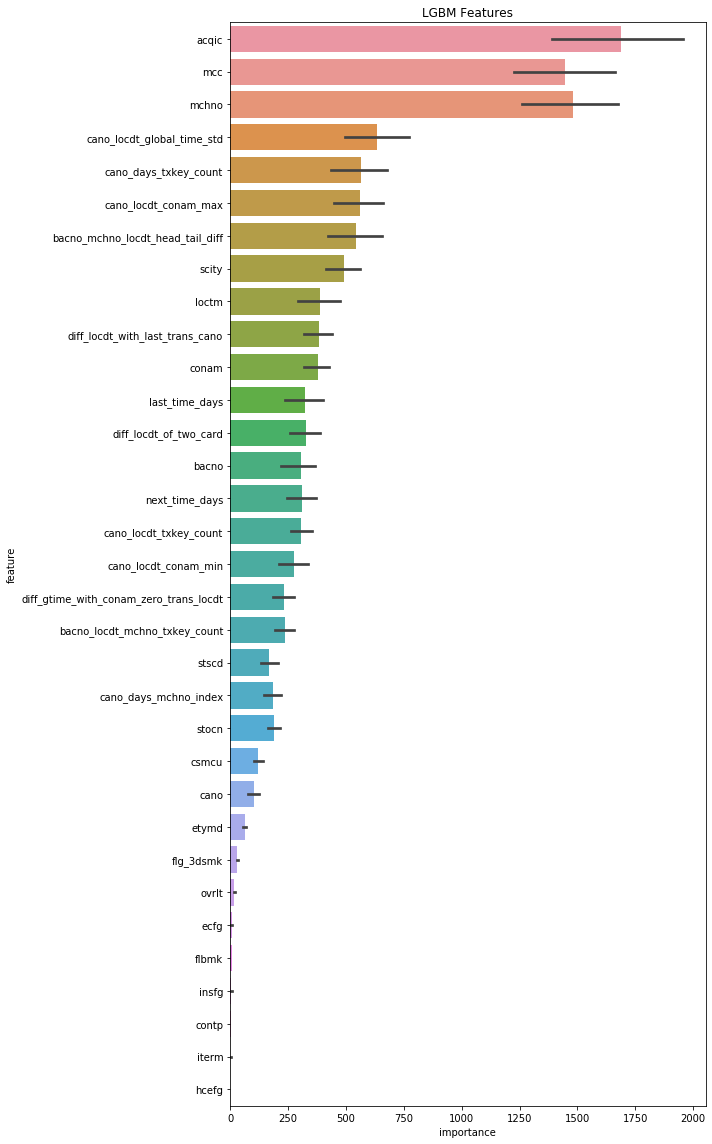

In [9]:
plot_importance(lgbm.df_feature_importance)

In [26]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,mean,max,min,std,upper_bound_1std,lower_bound_1std
0,0.000026,0.000053,1.702670e-05,0.000048,0.000015,0.000022,8.679415e-06,0.000030,0.000042,0.000019,0.000028,0.000053,8.679415e-06,0.000015,0.000044,1.287913e-05
1,0.000018,0.000016,1.277841e-05,0.000032,0.000028,0.000019,1.731371e-05,0.000057,0.000079,0.000008,0.000029,0.000079,8.407317e-06,0.000024,0.000052,4.971969e-06
2,0.000097,0.000158,8.536300e-05,0.000087,0.000092,0.000108,6.195400e-05,0.000089,0.000036,0.000090,0.000090,0.000158,3.608826e-05,0.000035,0.000126,5.514030e-05
3,0.000010,0.000018,6.540385e-06,0.000021,0.000008,0.000024,1.032669e-05,0.000013,0.000019,0.000014,0.000014,0.000024,6.540385e-06,0.000006,0.000020,8.401752e-06
4,0.000002,0.000004,6.513084e-07,0.000004,0.000001,0.000003,2.302098e-06,0.000003,0.000010,0.000003,0.000003,0.000010,6.513084e-07,0.000003,0.000006,2.977545e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421660,0.014595,0.011508,1.307217e-02,0.013241,0.014967,0.013992,1.631575e-02,0.012232,0.013574,0.012181,0.013568,0.016316,1.150791e-02,0.001539,0.015107,1.202833e-02
421661,0.011844,0.021519,1.459719e-02,0.017489,0.013560,0.012798,1.516507e-02,0.017268,0.013315,0.017279,0.015483,0.021519,1.184431e-02,0.003111,0.018595,1.237209e-02
421662,0.000354,0.001780,3.200192e-04,0.000858,0.000622,0.000341,5.440668e-04,0.000488,0.001525,0.000307,0.000714,0.001780,3.070553e-04,0.000538,0.001252,1.759727e-04
421663,0.000013,0.000023,1.460228e-05,0.000019,0.000023,0.000021,7.763647e-07,0.000029,0.000013,0.000008,0.000016,0.000029,7.763647e-07,0.000009,0.000025,7.543443e-06


In [27]:
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9]

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,mean,max,min,std,upper_bound_1std,lower_bound_1std
4383,0.147772,0.992668,0.077635,0.988949,0.995039,0.994347,0.988529,0.999589,0.992149,0.999410,0.817609,0.999589,0.077635,0.372263,1.189872,0.445346
4384,0.109055,0.990740,0.077863,0.986632,0.992479,0.993994,0.991361,0.985419,0.992513,0.989056,0.810911,0.993994,0.077863,0.375705,1.186617,0.435206
13550,0.024541,0.928729,0.962274,0.920485,0.946435,0.930541,0.953137,0.921080,0.907445,0.956788,0.845145,0.962274,0.024541,0.328182,1.173327,0.516964
53826,0.003498,0.955200,0.953507,0.896525,0.932631,0.916586,0.003587,0.003803,0.945761,0.941771,0.655287,0.955200,0.003498,0.423170,1.078457,0.232117
53827,0.002641,0.951211,0.968107,0.876686,0.943239,0.900645,0.002326,0.003372,0.945983,0.953801,0.654801,0.968107,0.002326,0.424582,1.079383,0.230219
53828,0.003675,0.947157,0.966913,0.880842,0.953925,0.927128,0.003086,0.005617,0.957464,0.942363,0.658817,0.966913,0.003086,0.425848,1.084664,0.232969
53829,0.004281,0.962018,0.972521,0.884843,0.950296,0.923236,0.003694,0.005707,0.960585,0.946541,0.661372,0.972521,0.003694,0.427368,1.088740,0.234004
53830,0.003990,0.964518,0.976256,0.887253,0.952417,0.929868,0.004835,0.005827,0.961785,0.957896,0.664465,0.976256,0.003990,0.429129,1.093593,0.235336
53831,0.003387,0.950596,0.965779,0.864411,0.945636,0.913115,0.004586,0.005283,0.961133,0.959289,0.657322,0.965779,0.003387,0.425036,1.082358,0.232285
53832,0.003973,0.961100,0.968052,0.884679,0.962472,0.921538,0.003070,0.001854,0.954662,0.966285,0.662768,0.968052,0.001854,0.428939,1.091707,0.233830


# Remove Outier

Since some of the predictions above are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [50]:
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9][['mean','mean_remove_outlier']]

,mean,mean_remove_outlier
4383,0.817609,0.993835
4384,0.810911,0.990274
13550,0.845145,0.936324
53826,0.655287,0.934569
53827,0.654801,0.934239
53828,0.658817,0.939399
53829,0.661372,0.942863
53830,0.664465,0.947142
53831,0.657322,0.937137
53832,0.662768,0.945541


In [52]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Whitelist of Merchant

In [64]:
input_features = features + [special_feautures[0]]
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train['mchno_in_normal_mchno_list'].unique()

array([0, 1])

In [67]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.818412	valid_1's Averge Precision: 0.705703
[200]	training's Averge Precision: 0.85623	valid_1's Averge Precision: 0.722421
[300]	training's Averge Precision: 0.878299	valid_1's Averge Precision: 0.73136
[400]	training's Averge Precision: 0.892896	valid_1's Averge Precision: 0.732535
[500]	training's Averge Precision: 0.904495	valid_1's Averge Precision: 0.735299
[600]	training's Averge Precision: 0.91277	valid_1's Averge Precision: 0.735476
Early stopping, best iteration is:
[513]	training's Averge Precision: 0.905616	valid_1's Averge Precision: 0.735538
Starting LightGBM. Fold 2,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.819335	valid_1's Averge Precision: 0.756673
[200]	training's Averge Precision: 0

[600]	training's Averge Precision: 0.91055	valid_1's Averge Precision: 0.724137
[700]	training's Averge Precision: 0.91761	valid_1's Averge Precision: 0.722399
Early stopping, best iteration is:
[610]	training's Averge Precision: 0.911471	valid_1's Averge Precision: 0.72419
Starting LightGBM. Fold 10,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.819601	valid_1's Averge Precision: 0.712786
[200]	training's Averge Precision: 0.857752	valid_1's Averge Precision: 0.7303
[300]	training's Averge Precision: 0.880324	valid_1's Averge Precision: 0.739779
[400]	training's Averge Precision: 0.894911	valid_1's Averge Precision: 0.74281
[500]	training's Averge Precision: 0.905871	valid_1's Averge Precision: 0.745837
[600]	training's Averge Precision: 0.914188	valid_1's Averge Precision: 0.745736
Early stopping, best iteration is:
[517]	training's Averge Precision: 0.90735	valid_1's Averge Prec

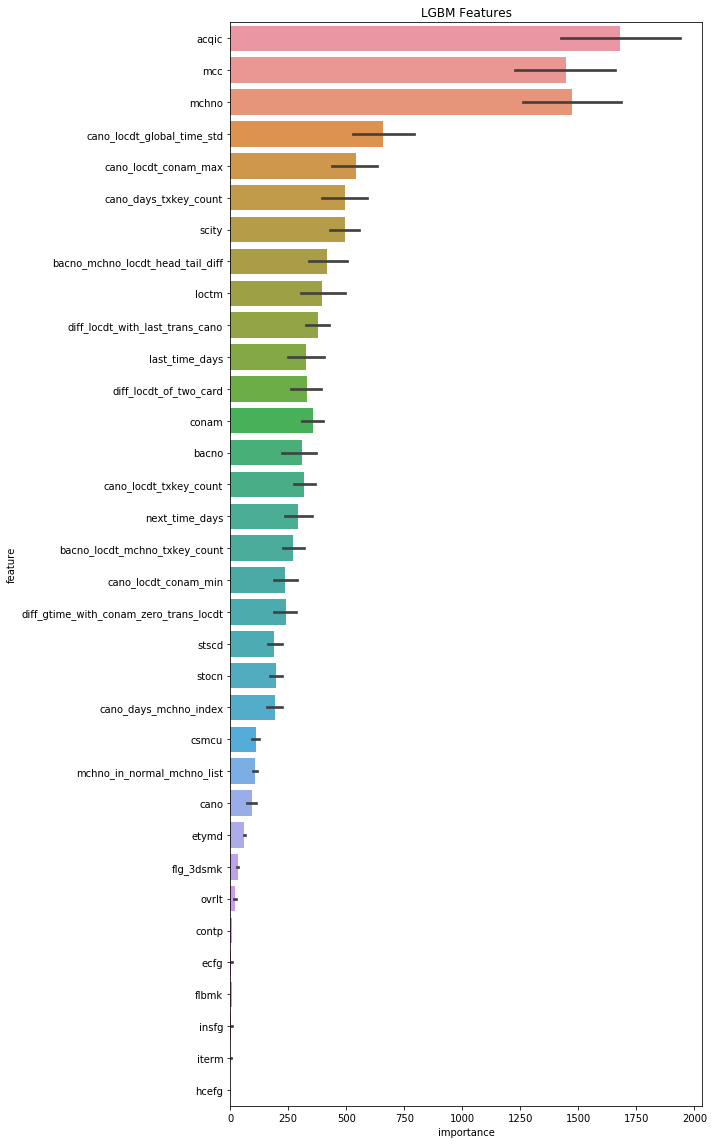

In [68]:
plot_importance(lgbm.df_feature_importance)

In [69]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_normal_mchno_model'] = oof_preds_LGBM
df_test['sub_normal_mchno_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Blacklist of Merchant

In [70]:
input_features = features + [special_feautures[1]]
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train['mchno_in_fraud_mchno_list'].unique()

array([0, 1])

In [71]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.81916	valid_1's Averge Precision: 0.729858
[200]	training's Averge Precision: 0.858547	valid_1's Averge Precision: 0.750317
[300]	training's Averge Precision: 0.880581	valid_1's Averge Precision: 0.758422
[400]	training's Averge Precision: 0.895902	valid_1's Averge Precision: 0.759415
[500]	training's Averge Precision: 0.906633	valid_1's Averge Precision: 0.760862
[600]	training's Averge Precision: 0.915517	valid_1's Averge Precision: 0.761009
Early stopping, best iteration is:
[522]	training's Averge Precision: 0.908655	valid_1's Averge Precision: 0.762067
Starting LightGBM. Fold 2,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.824942	valid_1's Averge Precision: 0.758871
[200]	training's Averge Precision:

Starting LightGBM. Fold 10,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.828842	valid_1's Averge Precision: 0.731806
[200]	training's Averge Precision: 0.864178	valid_1's Averge Precision: 0.74997
[300]	training's Averge Precision: 0.884118	valid_1's Averge Precision: 0.75462
[400]	training's Averge Precision: 0.898427	valid_1's Averge Precision: 0.757815
[500]	training's Averge Precision: 0.909149	valid_1's Averge Precision: 0.760738
[600]	training's Averge Precision: 0.917378	valid_1's Averge Precision: 0.761598
[700]	training's Averge Precision: 0.923676	valid_1's Averge Precision: 0.761289
Early stopping, best iteration is:
[626]	training's Averge Precision: 0.91933	valid_1's Averge Precision: 0.761991
Summary:
LGBM Testing_Set average_precision_score 0.773626


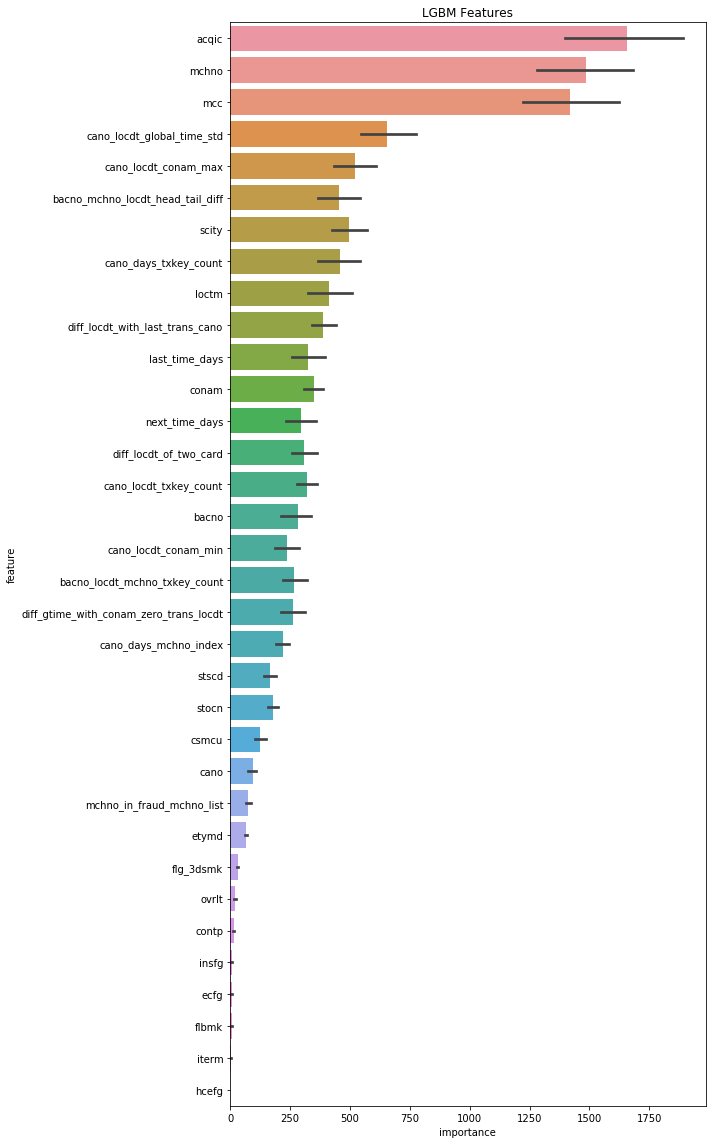

In [72]:
plot_importance(lgbm.df_feature_importance)

In [73]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_fraud_mchno_model'] = oof_preds_LGBM
df_test['sub_fraud_mchno_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Blacklist of Transaction Amount

In [75]:
input_features = features + [special_feautures[2]]
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train['conam_in_fraud_conam_list'].unique()

array([0, 1])

In [76]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.811446	valid_1's Averge Precision: 0.694879
[200]	training's Averge Precision: 0.848613	valid_1's Averge Precision: 0.710724
[300]	training's Averge Precision: 0.869345	valid_1's Averge Precision: 0.717086
[400]	training's Averge Precision: 0.885154	valid_1's Averge Precision: 0.719179
[500]	training's Averge Precision: 0.896385	valid_1's Averge Precision: 0.720251
Early stopping, best iteration is:
[448]	training's Averge Precision: 0.890957	valid_1's Averge Precision: 0.721148
Starting LightGBM. Fold 2,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.810499	valid_1's Averge Precision: 0.736461
[200]	training's Averge Precision: 0.848796	valid_1's Averge Precision: 0.749222
[300]	training's Averge Precision

Starting LightGBM. Fold 10,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.814484	valid_1's Averge Precision: 0.714891
[200]	training's Averge Precision: 0.851765	valid_1's Averge Precision: 0.729365
[300]	training's Averge Precision: 0.873376	valid_1's Averge Precision: 0.73792
[400]	training's Averge Precision: 0.889118	valid_1's Averge Precision: 0.738997
[500]	training's Averge Precision: 0.900616	valid_1's Averge Precision: 0.738614
Early stopping, best iteration is:
[414]	training's Averge Precision: 0.89091	valid_1's Averge Precision: 0.739546
Summary:
LGBM Testing_Set average_precision_score 0.758414


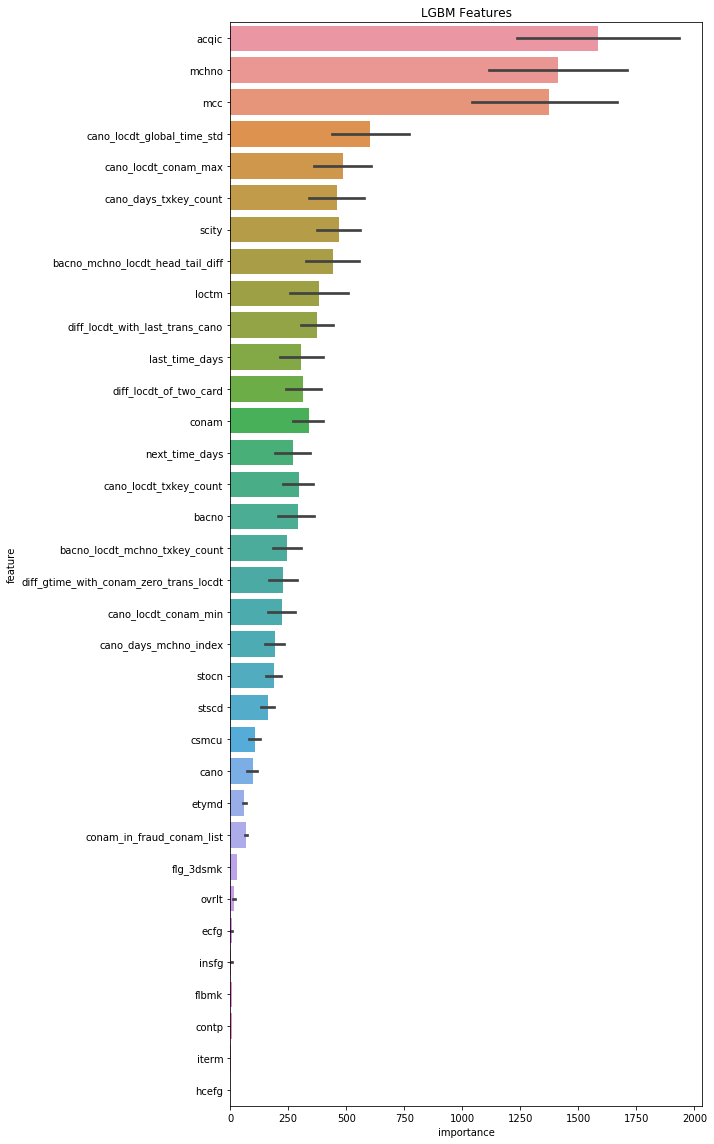

In [77]:
plot_importance(lgbm.df_feature_importance)

In [78]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_fraud_conam_model'] = oof_preds_LGBM
df_test['sub_fraud_conam_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Elapsed Day of First Fraudulent Transaction(if exist)

In [80]:
input_features = features + [special_feautures[3]]
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train['diff_with_first_fraud_locdt'].unique()

array([nan,  7.,  1., 12., 11., 14.,  9.,  2.,  5.,  8., 57.,  3., 15.,
        6., 13., 17., 18., 21., 22., 23., 30., 16., 28., 31., 41., 51.,
       52., 71., 34.,  4., 24., 19., 26., 27., 36., 37., 33., 42., 44.,
       45., 10., 46., 47., 56., 58., 61., 63., 29., 20., 50., 55., 38.,
       39., 49., 70., 72., 74., 25., 43., 54., 48., 35., 32., 53., 40.,
       62., 60., 59., 75., 64., 67., 68., 69., 73., 76., 77., 80., 81.,
       83., 88., 65., 78., 79., 82., 87., 66., 84., 85.])

In [81]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10)

Starting LightGBM. Fold 1,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.829469	valid_1's Averge Precision: 0.733162
[200]	training's Averge Precision: 0.866876	valid_1's Averge Precision: 0.751671
[300]	training's Averge Precision: 0.886737	valid_1's Averge Precision: 0.757203
[400]	training's Averge Precision: 0.901138	valid_1's Averge Precision: 0.760367
[500]	training's Averge Precision: 0.912363	valid_1's Averge Precision: 0.761097
[600]	training's Averge Precision: 0.920798	valid_1's Averge Precision: 0.762246
Early stopping, best iteration is:
[546]	training's Averge Precision: 0.916543	valid_1's Averge Precision: 0.762675
Starting LightGBM. Fold 2,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.832287	valid_1's Averge Precision: 0.760336
[200]	training's Averge Precision

[700]	training's Averge Precision: 0.926281	valid_1's Averge Precision: 0.738385
[800]	training's Averge Precision: 0.93199	valid_1's Averge Precision: 0.738657
[900]	training's Averge Precision: 0.936828	valid_1's Averge Precision: 0.739468
Early stopping, best iteration is:
[832]	training's Averge Precision: 0.93364	valid_1's Averge Precision: 0.739657
Starting LightGBM. Fold 10,Train shape: (1521787, 34), test shape: (421665, 34)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.830564	valid_1's Averge Precision: 0.723363
[200]	training's Averge Precision: 0.869687	valid_1's Averge Precision: 0.743391
[300]	training's Averge Precision: 0.890312	valid_1's Averge Precision: 0.749341
[400]	training's Averge Precision: 0.904875	valid_1's Averge Precision: 0.752328
[500]	training's Averge Precision: 0.915167	valid_1's Averge Precision: 0.754522
[600]	training's Averge Precision: 0.92307	valid_1's Averge Precision: 0.756308
[700]	training'

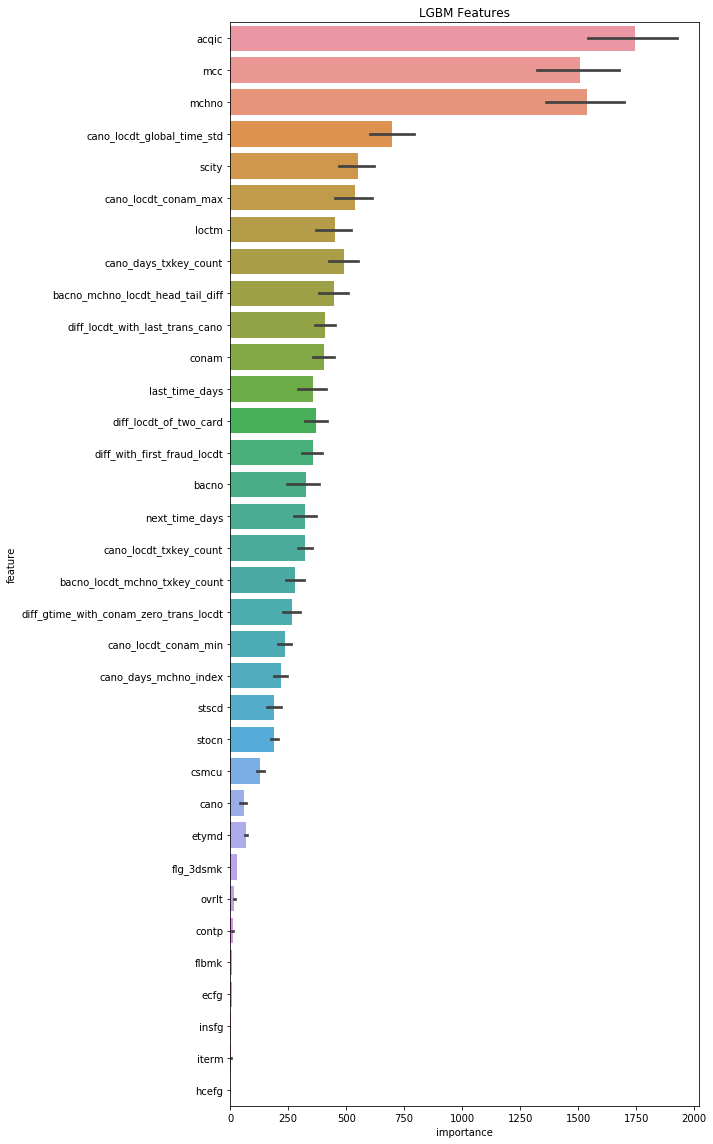

In [82]:
plot_importance(lgbm.df_feature_importance)

In [83]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_first_fraud_model'] = oof_preds_LGBM
df_test['sub_first_fraud_model'] = df_sub_preds_statistics['mean_remove_outlier']

## Find the range of threshold which maximizes the f1 score

In [88]:
for i in range(0,70):
    print (i, f1_score(y_train, np.where(df_train['oof_base_model']>i/100,1,0) ))

0 0.026398347233912316
1 0.334324838073782
2 0.41573913339460156
3 0.46916151483595436
4 0.5085976810325968
5 0.5371595147791743
6 0.5609853395831256
7 0.5794314526645222
8 0.5944715447154473
9 0.6054265734265735
10 0.6162757245056483
11 0.6239277652370203
12 0.6313911771190347
13 0.6371569288619132
14 0.6425062447960033
15 0.6472031818566473
16 0.6511787840364488
17 0.654620840152755
18 0.6577673657922072
19 0.6603862247980488
20 0.6636939791760977
21 0.6659488683221846
22 0.6690140845070423
23 0.670723715007958
24 0.6727109175267493
25 0.674050330111951
26 0.6756378044066488
27 0.6771496135937004
28 0.6788335549972908
29 0.6793081167056017
30 0.6804361448803109
31 0.6817618963382275
32 0.6829031929001327
33 0.6832990750256938
34 0.6835364433749904
35 0.68392540889676
36 0.6843319180164595
37 0.6840105540897097
38 0.6840371845949534
39 0.6833840730652139
40 0.6831547571094819
41 0.6832761369470641
42 0.6831481431171724
43 0.6819088202354613
44 0.6816808569074431
45 0.6808240362310836


## Create Submission

Use different models to predict based on different condiitons. Change the threshold to create submission. 

In [ ]:
threshold = 0.3

# Use base model for default
df_test['fraud_ind'] = np.where(df_test['sub_base_model']> threshold, 1, 0)

df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==1) & (df_test['sub_fraud_mchno_model'] > threshold), 1, df_test['fraud_ind'])
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==1) & (df_test['sub_fraud_mchno_model'] <= threshold), 0, df_test['fraud_ind'])

df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['diff_with_first_fraud_locdt'] >= 1) & (df_test['sub_first_fraud_model'] > threshold), 1, df_test['fraud_ind'])

df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['mchno_in_normal_mchno_list']>0) & (df_test['sub_normal_mchno_model'] > threshold), 1, df_test['fraud_ind'])
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['mchno_in_normal_mchno_list']>0) & (df_test['sub_normal_mchno_model'] <= threshold), 0, df_test['fraud_ind'])

df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['conam_in_fraud_conam_list']==1) & (df_test['sub_fraud_conam_model'] > threshold), 1, df_test['fraud_ind'])
df_test['fraud_ind'] = np.where((df_test['mchno_in_fraud_mchno_list']==0) & (df_test['conam_in_fraud_conam_list']==1) & (df_test['sub_fraud_conam_model'] <= threshold), 0, df_test['fraud_ind'])

df_test[['txkey','fraud_ind']].to_csv('sub_{}.csv'.format(threshold),index = False)